# 大黒海釣り施設、アジ以外の魚種の分析その１

## モジュールのインポート

In [1]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [15, 10]

# seaborn グラフにグリッド線を追加

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## データのロードと変換

In [3]:
# 大黒、アジ以外の魚種で、SQLite3データベースを検索

conn = sqlite3.connect("../data/fishing_result.db")
sql = '''
select
    r.Date,
    r.Species,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity
from
    fishing_results r,
    fishing_comments c
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Species != 'アジ'
    and r.Point = 'daikoku'
    and r.Date >= '2018-01-01'
'''
df=pd.read_sql_query(sql, conn)
df.head()

,Date,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity
0,2018-01-02,ウミタナゴ,19,15.0,25.0,12.0,161.0
1,2018-01-02,カサゴ,17,12.0,22.0,12.0,161.0
2,2018-01-02,クジメ,1,17.0,17.0,12.0,161.0
3,2018-01-02,シャコ,1,15.0,15.0,12.0,161.0
4,2018-01-02,シロギス,1,18.0,18.0,12.0,161.0


In [4]:
# 日本語の文字化け対策のため、魚種をローマ字に変換

def get_spieces_alphabet(spieces):
    if spieces == 'クロダイ':
        return 'Kurodai'
    elif spieces == 'メジナ':
        return 'Mejina'
    elif spieces == 'メバル':
        return 'Mebaru'
    elif spieces == 'カサゴ':
        return 'Kasago'
    else:
        return 'Etc'

df['Species'] = df.apply(lambda x: get_spieces_alphabet(x.Species), axis=1)

df.head()

,Date,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity
0,2018-01-02,Etc,19,15.0,25.0,12.0,161.0
1,2018-01-02,Kasago,17,12.0,22.0,12.0,161.0
2,2018-01-02,Etc,1,17.0,17.0,12.0,161.0
3,2018-01-02,Etc,1,15.0,15.0,12.0,161.0
4,2018-01-02,Etc,1,18.0,18.0,12.0,161.0


In [5]:
# 土日祝日化判定列を追加

df['Date'] = pd.to_datetime(df.Date)
def isBizDay(Date):
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 'Holiday'
    else:
        return 'WeekDay'

df['BizDay'] = df.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセット

df = df.set_index('Date')

# 年月日列を追加

df['Year'] = df.index.year
df['Month'] = df.index.month
df['DayOfYear'] = df.index.dayofyear
df['WeekOfYear'] = df.index.strftime('%U').astype(int) # df3.index.week

df.head()

,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,,,,,
2018-01-02,Etc,19,15.0,25.0,12.0,161.0,WeekDay,2018,1,2,0
2018-01-02,Kasago,17,12.0,22.0,12.0,161.0,WeekDay,2018,1,2,0
2018-01-02,Etc,1,17.0,17.0,12.0,161.0,WeekDay,2018,1,2,0
2018-01-02,Etc,1,15.0,15.0,12.0,161.0,WeekDay,2018,1,2,0
2018-01-02,Etc,1,18.0,18.0,12.0,161.0,WeekDay,2018,1,2,0


## 魚種別釣果の分析

<AxesSubplot:xlabel='Month', ylabel='Count'>

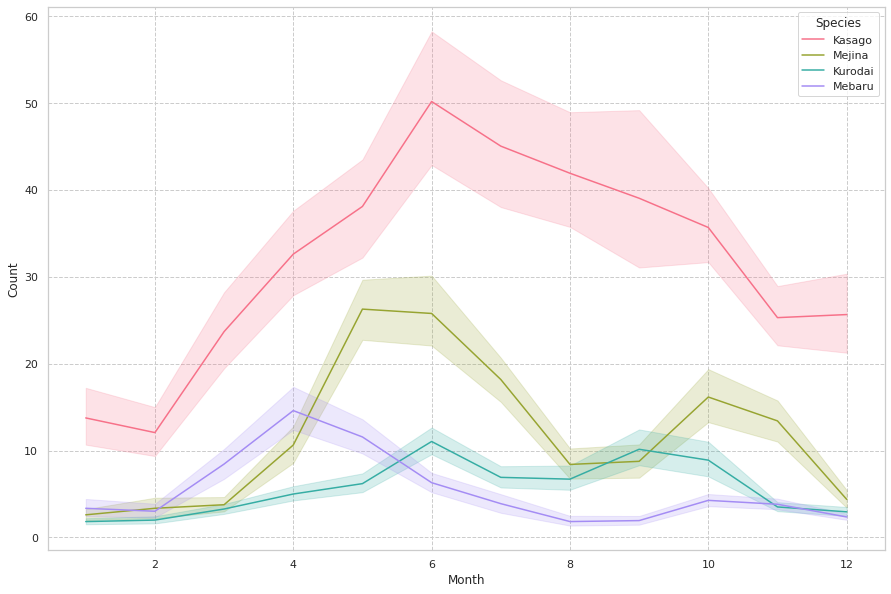

In [6]:
# その他の魚種の釣果を取り除く

df3 = df.query('Species != "Etc"')

# 魚種別釣果数
sns.lineplot(data=df3, x='Month', y='Count', hue='Species', 
            markers=True, dashes=False, palette="husl")

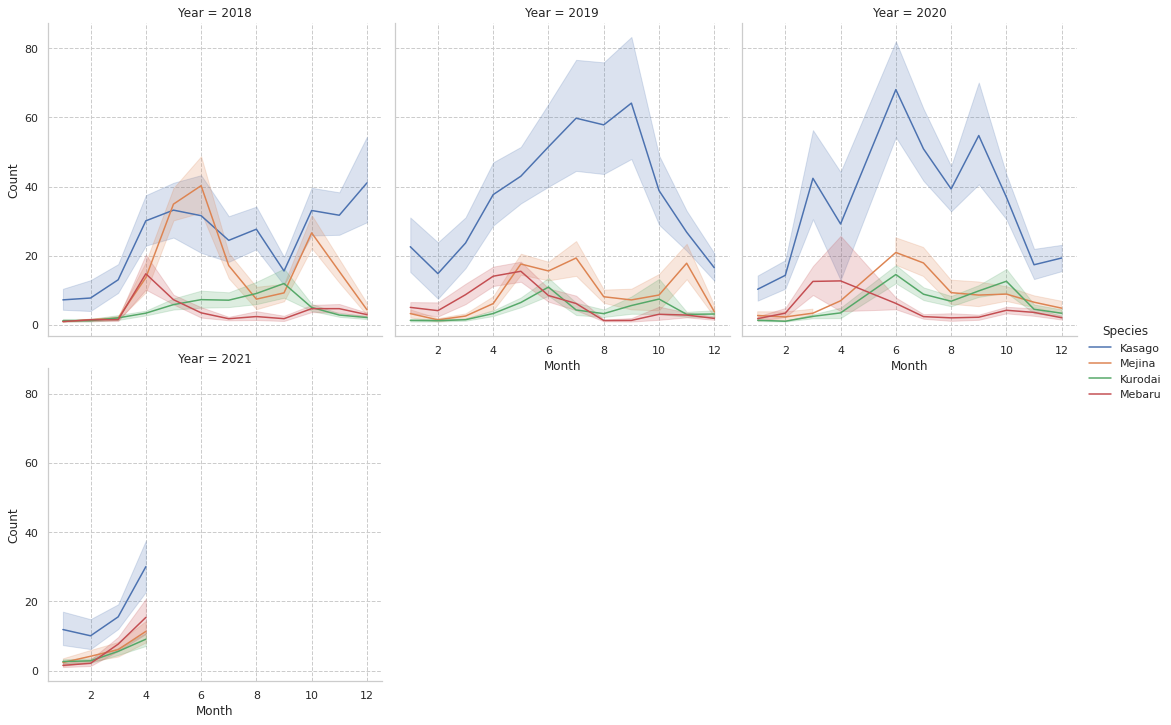

In [7]:
# 魚種別釣果数、各年度グラフ

sns.relplot(data=df3, x='Month', y='Count', hue='Species', col='Year', kind="line", col_wrap=3)

<AxesSubplot:xlabel='Species', ylabel='Count'>

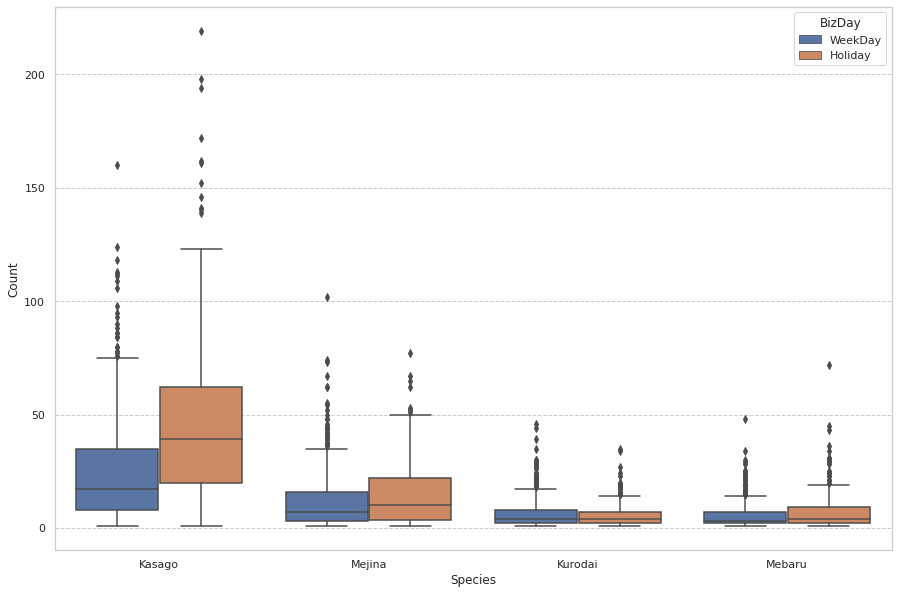

In [8]:
# 平日、休日の違い、魚種別釣果数

sns.boxplot(data=df3, x='Species', y='Count', hue='BizDay')

<AxesSubplot:xlabel='Species', ylabel='SizeMax'>

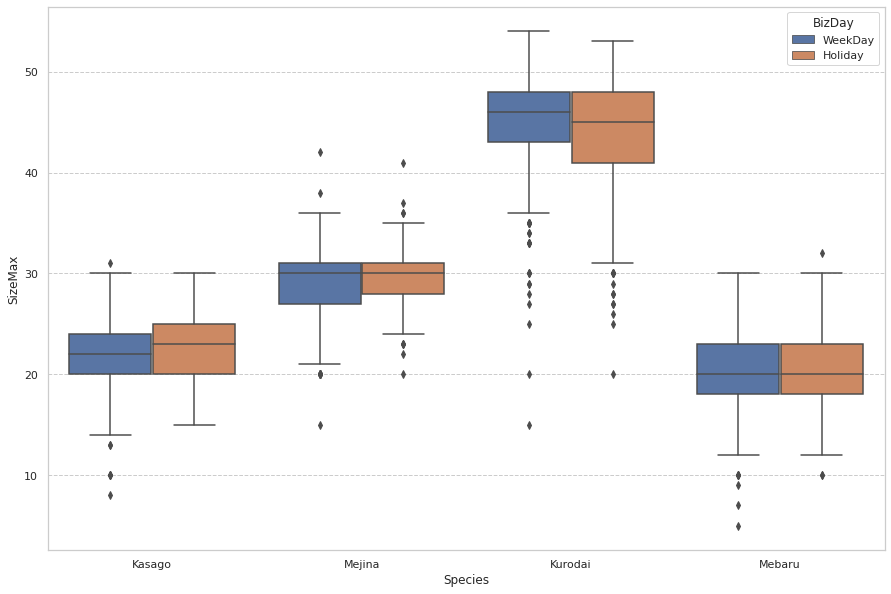

In [9]:
# 平日、休日の違い、魚種最大サイズ

sns.boxplot(data=df3, x='Species', y='SizeMax', hue='BizDay')

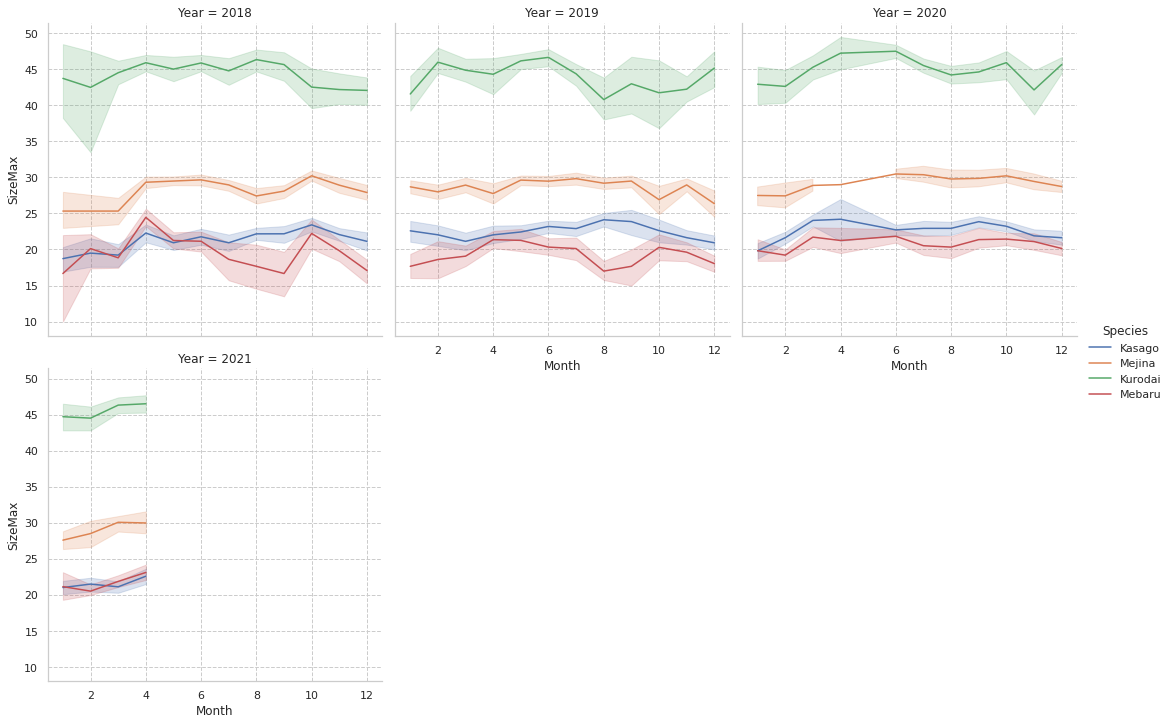

In [10]:
# 魚種サイズ、各年度グラフ

sns.relplot(data=df3, x='Month', y='SizeMax', hue='Species', col='Year', kind="line", col_wrap=3)

## クロダイの釣果分析

<AxesSubplot:xlabel='Month', ylabel='Count'>

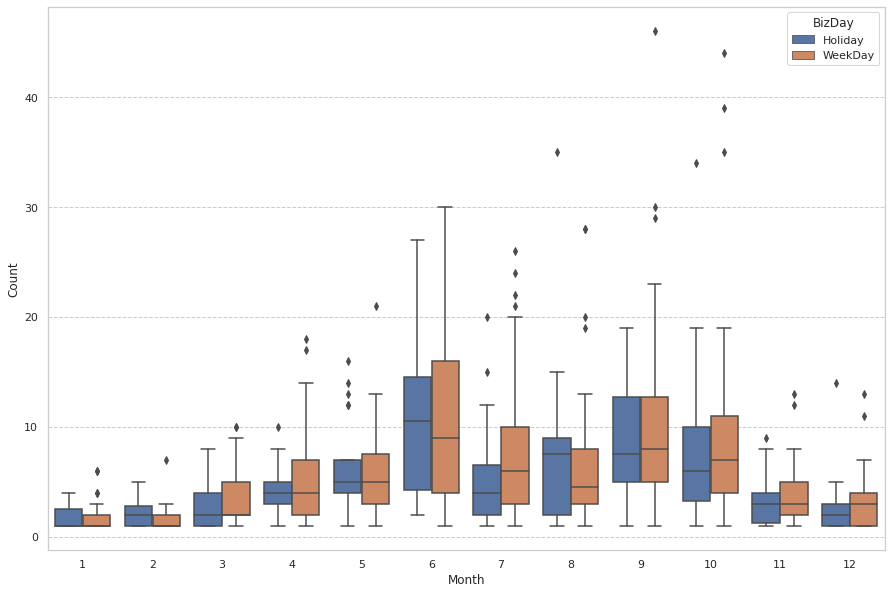

In [11]:
# クロダイに絞り込む

df5 = df3.loc[df3['Species'].isin(['Kurodai'])]

# 月別の平日、休日の釣果数

sns.boxplot(data = df5, x="Month", y="Count", hue="BizDay")

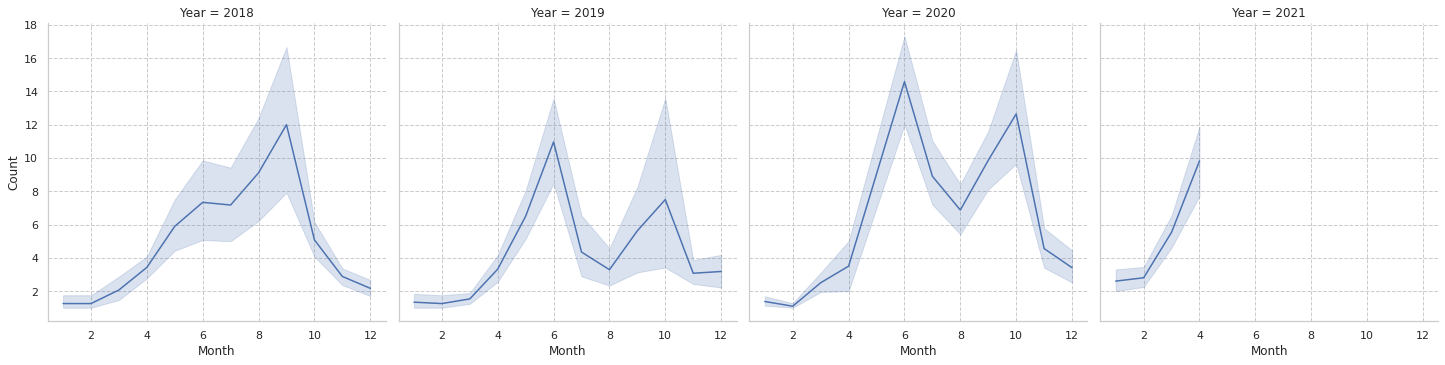

In [26]:
# 年度別クロダイ釣果数

sns.relplot(data=df5, x='Month', y='Count', col='Year', kind="line")

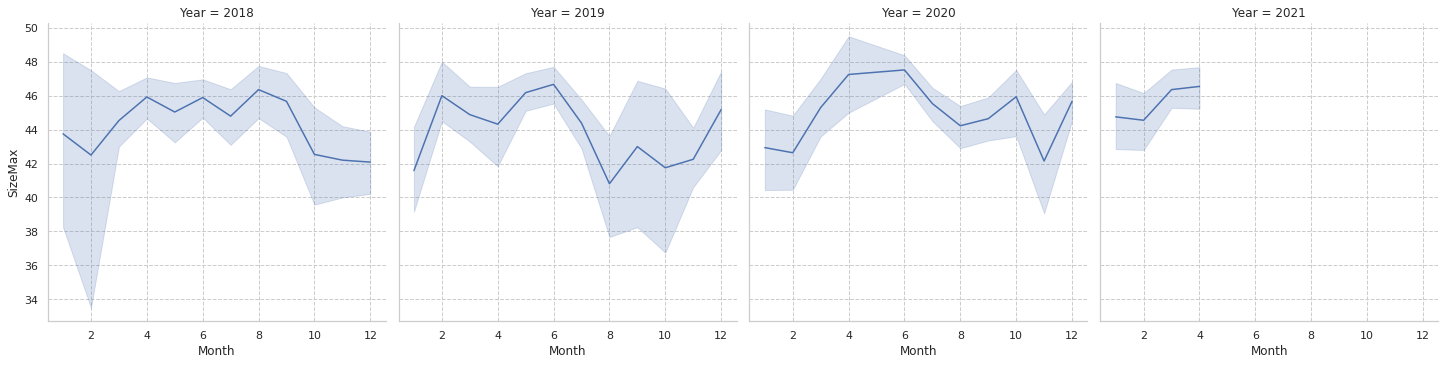

In [14]:
# 年度別クロダイ最大サイズ

sns.relplot(data=df5, x='Month', y='SizeMax', col='Year', kind="line")